In [1]:
import pandas as pd
import re
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from math import radians, sin, cos, asin, sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
InteractiveShell.ast_node_interactivity ='all'

pd.set_option('display.max_columns', None)    #显示所有列
pd.set_option('display.max_rows', 30)    #显示所有行
pd.set_option('max_colwidth',100)    #设置value的显示长度为100，默认为50

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier

# 集成分类库和投票方法库
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
# StratifiedKFold：适用于有标签数据集的交叉检验数据集划分方法。cross_val_score：通过交叉检验方法做模型效果评估。导入交叉检验算法
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [149]:
df_train = pd.read_csv('data_use_2.csv')
df_train.head(1)
df_train.shape

,PICK_UP_EARLIST,RECEIVE_VOLUME,BUSINESS_TYPE,VOLUME,WEIGHT,QUANTITY,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,VEHICLE_LENGTH,EQUAL_VOLUME,UNLOAD_TIME,FREIGHT_BASIS_LABEL,COMPANY_LABEL
0,2019-09-08 11:29:35,1.325,B,5.28,368.5,55.0,368.5,5.28,6,17.5,1,5.563,0,11


(518187, 14)

In [150]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
df_train['UNLOAD_TIME'].describe()

count    518187.000000
mean         11.894137
std          12.815372
min           0.250000
25%           3.718000
50%           7.339000
75%          14.641000
max          71.989000
Name: UNLOAD_TIME, dtype: float64

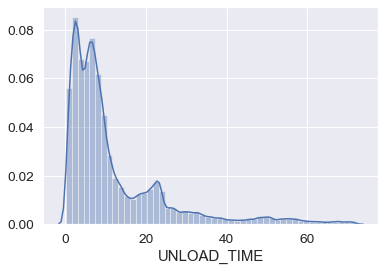

In [152]:
sns.distplot(df_train['UNLOAD_TIME']);

In [14]:
# 偏度和峰度
print("Skewness: %f" % df_train['UNLOAD_TIME'].skew())
print("Kurtosis: %f" % df_train['UNLOAD_TIME'].kurt())

Skewness: 2.144035
Kurtosis: 4.815971


In [153]:
var = 'PICK_UP_EARLIST'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)
data
# data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,800000));    # 这个看不出关系来的，，

,UNLOAD_TIME,PICK_UP_EARLIST
0,5.563,2019-09-08 11:29:35
1,5.555,2019-09-08 11:29:35
2,5.559,2019-09-08 11:29:35
3,0.892,2019-04-19 09:57:37
4,0.746,2019-10-01 15:48:06
...,...,...
518182,23.071,2019-10-17 09:31:48
518183,49.643,2019-10-16 09:45:45
518184,18.969,2019-10-18 13:39:45
518185,49.643,2019-10-16 09:45:45


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


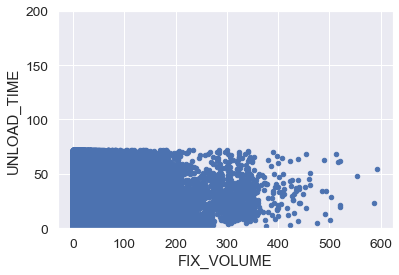

In [154]:
var = 'FIX_VOLUME'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)    #  对结果表示  不能理解。。
data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,200));

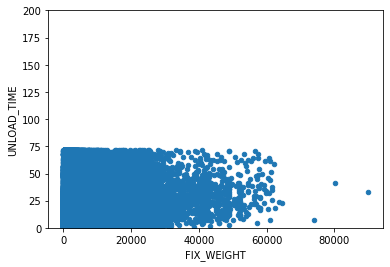

In [36]:
var = 'FIX_WEIGHT'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)   
data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,200));

In [155]:
df_train[df_train['WEIGHT'] > 65000]
df_train[df_train['WEIGHT'] > 65000].index

,PICK_UP_EARLIST,RECEIVE_VOLUME,BUSINESS_TYPE,VOLUME,WEIGHT,QUANTITY,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,VEHICLE_LENGTH,EQUAL_VOLUME,UNLOAD_TIME,FREIGHT_BASIS_LABEL,COMPANY_LABEL
431055,2019-11-22 14:13:00,116.654,B,233.308000,80300.0,7000.0,80300.0,233.308000,48,17.5,1,41.447,1,16
434436,2019-11-23 08:31:01,125.946,B,251.892288,89911.2,7544.0,89911.2,251.892288,48,17.5,1,33.199,1,16
440370,2019-11-30 08:33:26,150.368,B,150.368000,74000.0,4000.0,74000.0,150.368000,8,21.0,0,7.665,1,16


Int64Index([431055, 434436, 440370], dtype='int64')

In [156]:
df_train = df_train.drop(index=[431055, 434436, 440370])
df_train[df_train['WEIGHT'] > 65000]

,PICK_UP_EARLIST,RECEIVE_VOLUME,BUSINESS_TYPE,VOLUME,WEIGHT,QUANTITY,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,VEHICLE_LENGTH,EQUAL_VOLUME,UNLOAD_TIME,FREIGHT_BASIS_LABEL,COMPANY_LABEL


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


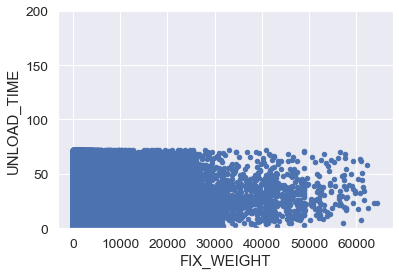

In [157]:
var = 'FIX_WEIGHT'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)   
data.plot.scatter(x=var, y='UNLOAD_TIME', ylim=(0,200));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


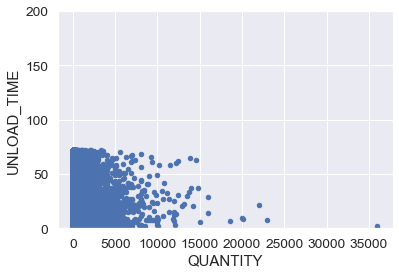

In [158]:
var = 'QUANTITY'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)   
data.plot.scatter(x=var, y='UNLOAD_TIME',ylim=(0,200));

In [159]:
df_train[df_train['QUANTITY'] > 15000].index

Int64Index([263816, 400558, 401697, 409740, 409816, 409871, 410027, 464256], dtype='int64')

In [162]:
df_train = df_train.drop(df_train[df_train['QUANTITY'] > 15000].index)
df_train.shape

(518176, 14)

In [160]:
df_train.shape

(518184, 14)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


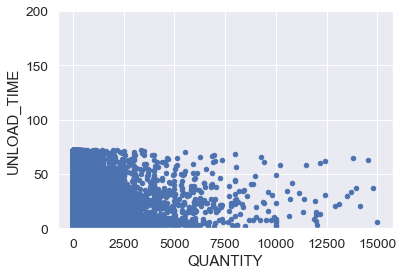

In [163]:
var = 'QUANTITY'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)   
data.plot.scatter(x=var, y='UNLOAD_TIME',ylim=(0,200));

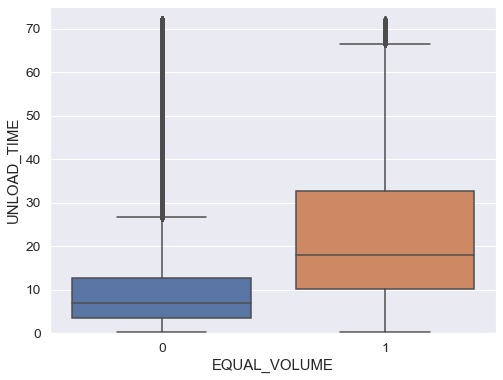

In [164]:
#   和分类变量的关系
var = 'EQUAL_VOLUME'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)    #  无法解释这么多异常值。。。全删除？
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="UNLOAD_TIME", data=data)
fig.axis(ymin=0, ymax=75);

In [165]:
df_1  = pd.DataFrame(data[data['EQUAL_VOLUME'] == 1]['UNLOAD_TIME'])
df_1[df_1['UNLOAD_TIME'] > 65].index

Int64Index([  1512,   1536,   1560,   4518,   4554,   5062,   5181,   7184,
              7190,   9116,
            ...
            510475, 510482, 512101, 513054, 513166, 515246, 515717, 515718,
            515719, 516892],
           dtype='int64', length=815)

In [166]:
df_train.shape

(518176, 14)

In [167]:
df_train = df_train.drop(index = list(df_1[df_1['UNLOAD_TIME'] > 65].index))
df_train.shape

(517361, 14)

In [168]:
df_2  = pd.DataFrame(data[data['EQUAL_VOLUME'] == 0]['UNLOAD_TIME'])
df_2[df_2['UNLOAD_TIME'] > 28].index

Int64Index([   125,    126,    127,    128,    129,    130,    131,    138,
               139,    194,
            ...
            518047, 518048, 518049, 518050, 518085, 518088, 518089, 518107,
            518108, 518109],
           dtype='int64', length=38324)

In [169]:
df_train = df_train.drop(index = list(df_2[df_2['UNLOAD_TIME'] > 28].index))
df_train.shape

(479037, 14)

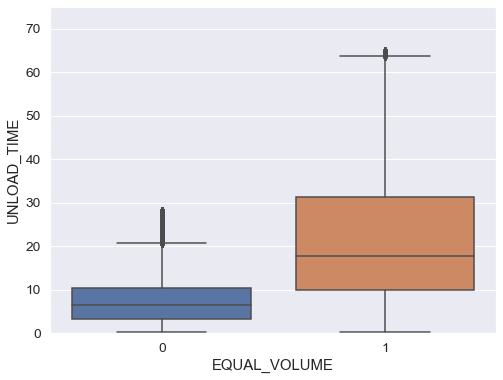

In [170]:
var = 'EQUAL_VOLUME'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)    
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="UNLOAD_TIME", data=data)
fig.axis(ymin=0, ymax=75);

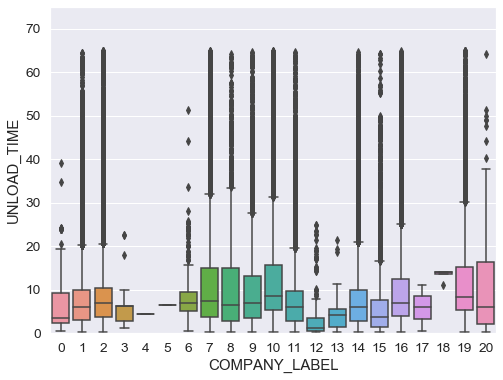

In [171]:
var = 'COMPANY_LABEL'
data = pd.concat([df_train['UNLOAD_TIME'], df_train[var]], axis=1)       #   这个变量在计划中不是特别重要  忽略异常值吧，，
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="UNLOAD_TIME", data=data)
fig.axis(ymin=0, ymax=75);

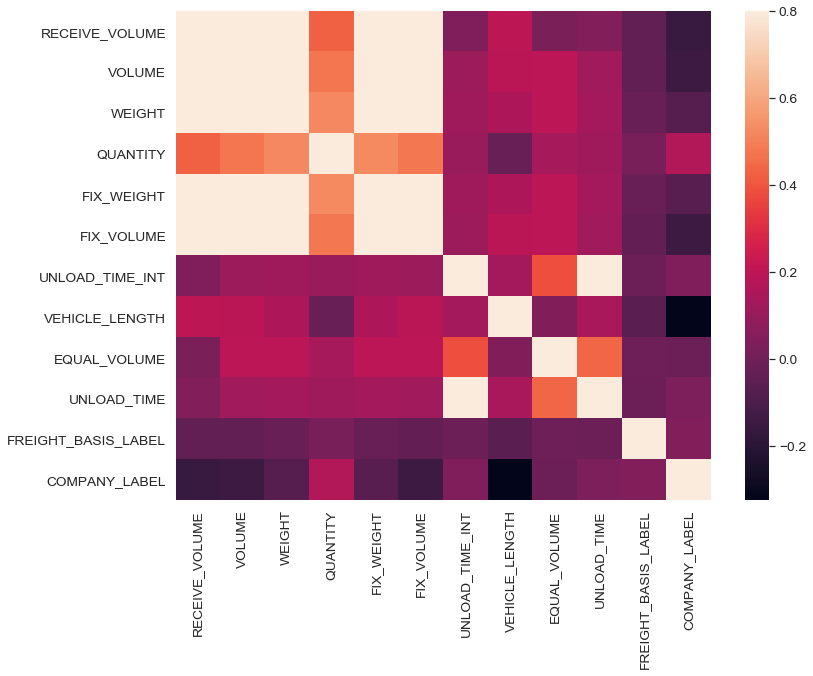

In [172]:
corrmat  = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8)

###  和卸货时间相关的变量  除了自身几乎没了。。

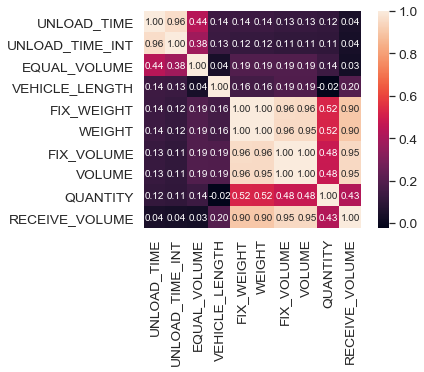

In [173]:
k = 10 
cols = corrmat.nlargest(k, 'UNLOAD_TIME')['UNLOAD_TIME'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

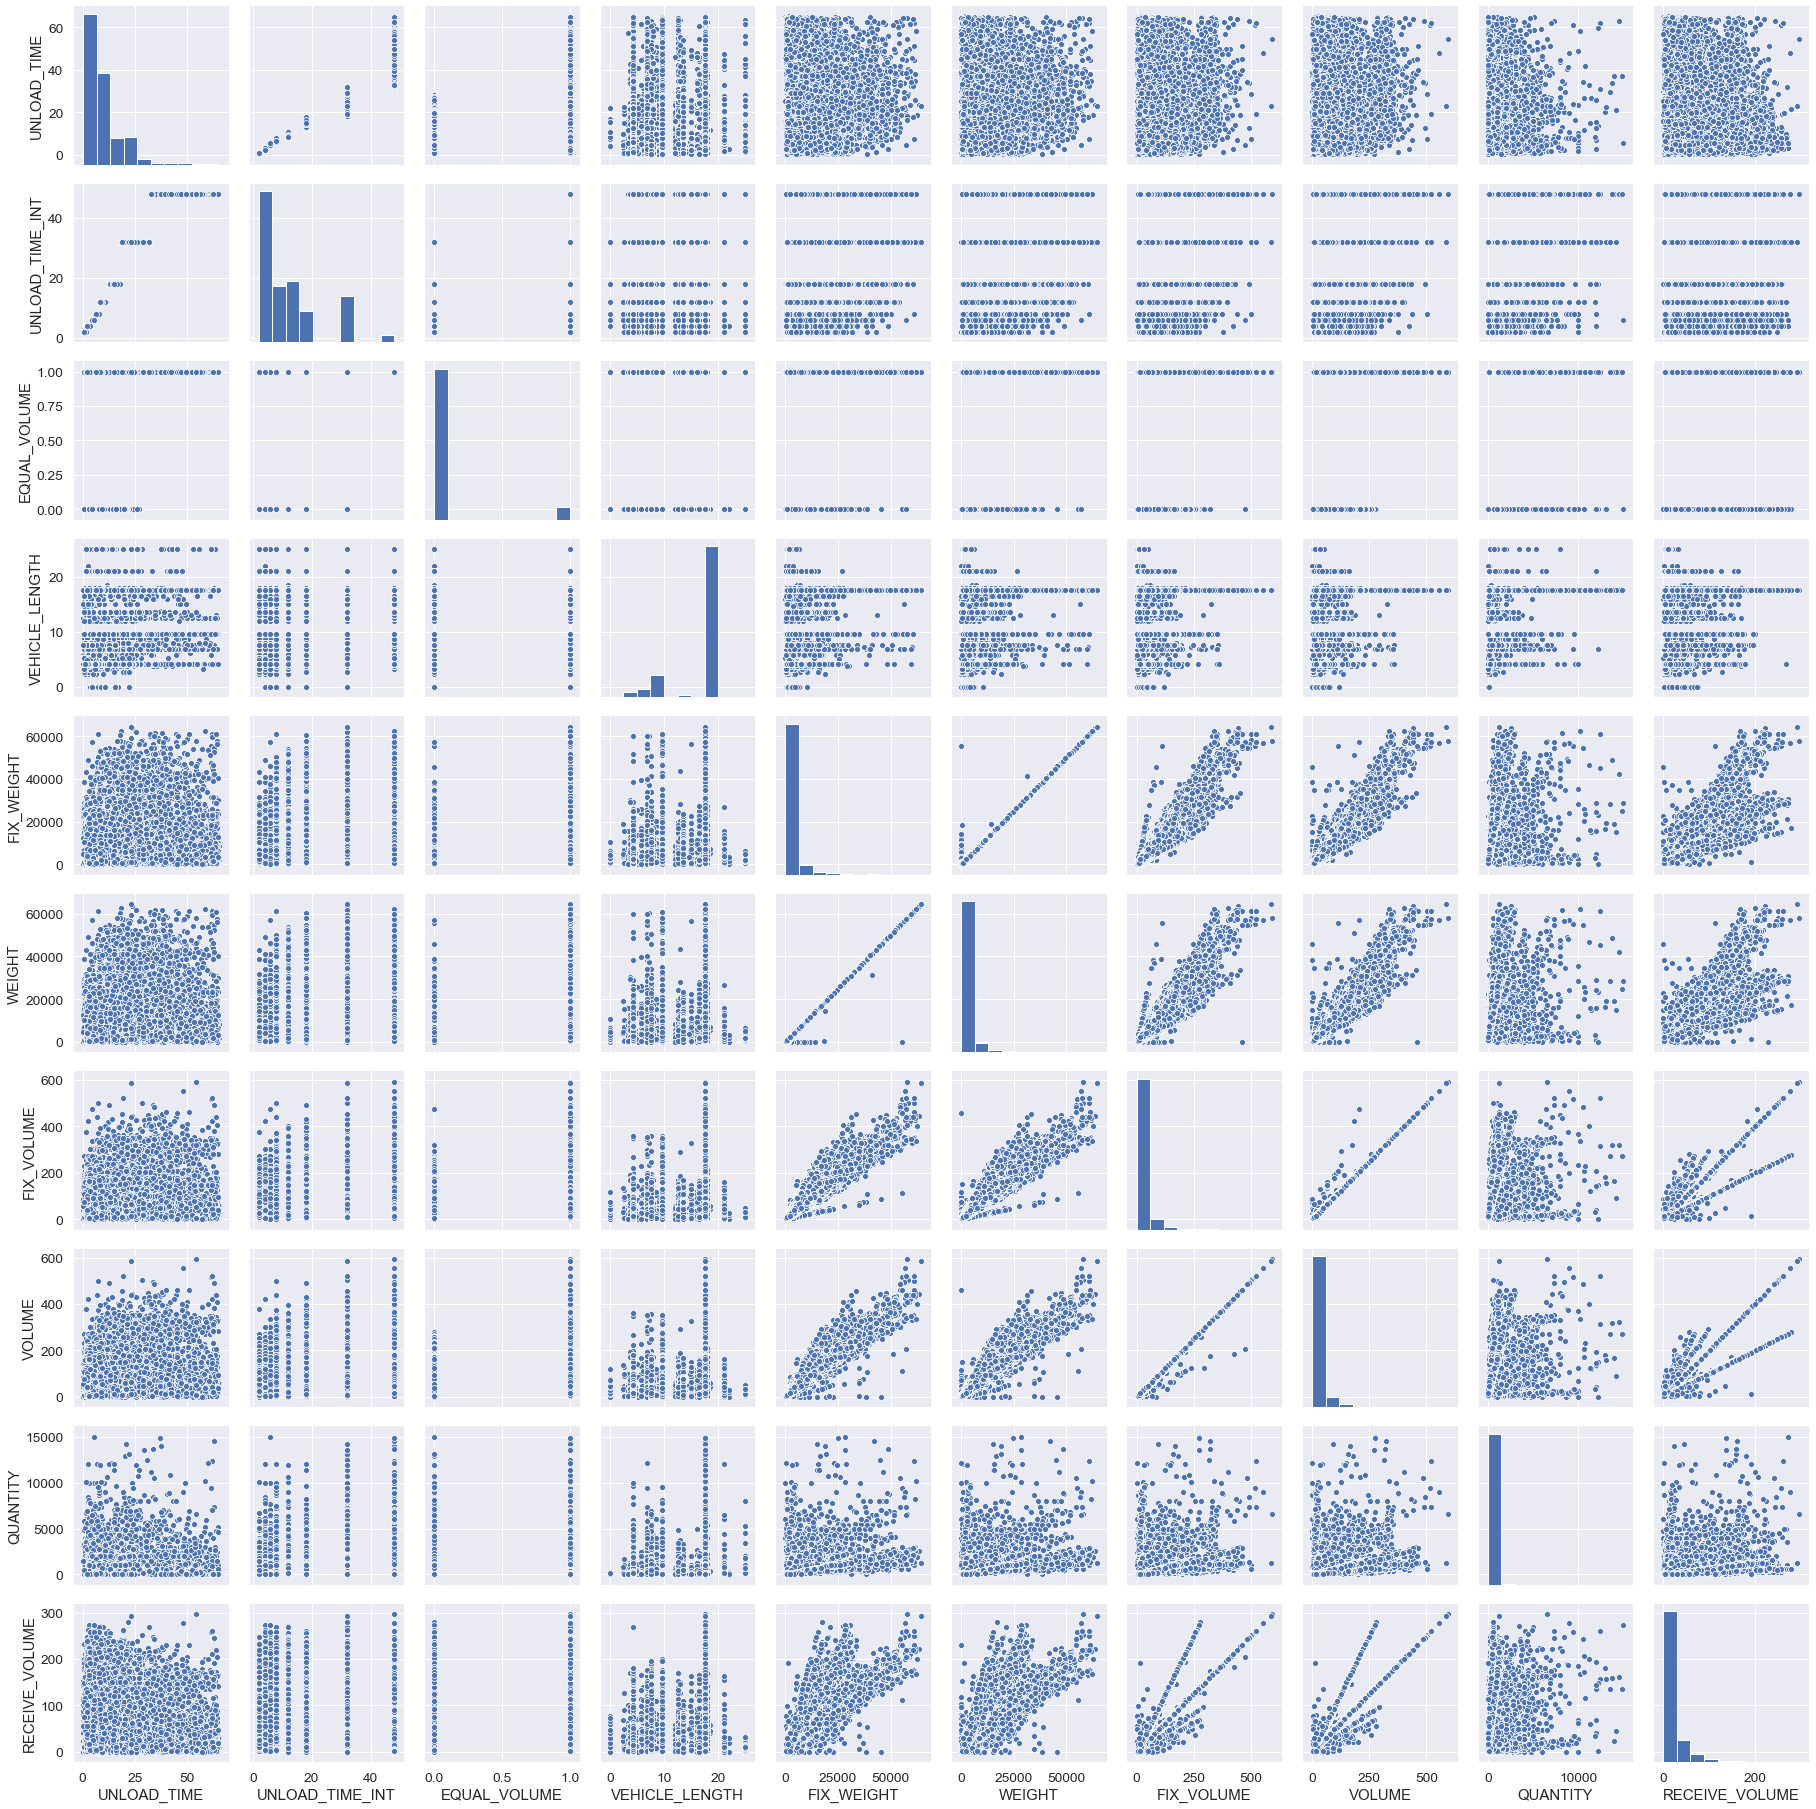

In [108]:
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

###  处理数据倾斜

In [174]:
cols = ('RECEIVE_VOLUME','VOLUME','WEIGHT','QUANTITY','VEHICLE_LENGTH','UNLOAD_TIME')

for c in cols:
    df_train[c] = np.log(df_train[c])

In [177]:
df_train.shape
df_train.head(1)

(479037, 14)

,PICK_UP_EARLIST,RECEIVE_VOLUME,BUSINESS_TYPE,VOLUME,WEIGHT,QUANTITY,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,VEHICLE_LENGTH,EQUAL_VOLUME,UNLOAD_TIME,FREIGHT_BASIS_LABEL,COMPANY_LABEL
0,2019-09-08 11:29:35,0.281412,B,1.663926,5.909441,4.007333,368.5,5.28,6,2.862201,1,1.716138,0,11


In [186]:
df_train.min()

PICK_UP_EARLIST        2019-01-01 08:11:24
RECEIVE_VOLUME                        -inf
BUSINESS_TYPE                            B
VOLUME                            -9.21034
WEIGHT                                -inf
QUANTITY                                 0
FIX_WEIGHT                               0
FIX_VOLUME                          0.0001
UNLOAD_TIME_INT                          2
VEHICLE_LENGTH                        -inf
EQUAL_VOLUME                             0
UNLOAD_TIME                       -1.38629
FREIGHT_BASIS_LABEL                      0
COMPANY_LABEL                            0
dtype: object

In [187]:
# train_inf = np.isinf(df_train.values)
# train[train_inf] = 0

df_train = df_train.replace([np.inf, -np.inf], 0)      #  替换掉 负无穷值
df_train.min()

PICK_UP_EARLIST        2019-01-01 08:11:24
RECEIVE_VOLUME                    -6.90776
BUSINESS_TYPE                            B
VOLUME                            -9.21034
WEIGHT                            -2.30259
QUANTITY                                 0
FIX_WEIGHT                               0
FIX_VOLUME                          0.0001
UNLOAD_TIME_INT                          2
VEHICLE_LENGTH                           0
EQUAL_VOLUME                             0
UNLOAD_TIME                       -1.38629
FREIGHT_BASIS_LABEL                      0
COMPANY_LABEL                            0
dtype: object

In [188]:
total = df_train.isnull().sum().sort_values(ascending=False)
total

COMPANY_LABEL          0
FREIGHT_BASIS_LABEL    0
UNLOAD_TIME            0
EQUAL_VOLUME           0
VEHICLE_LENGTH         0
UNLOAD_TIME_INT        0
FIX_VOLUME             0
FIX_WEIGHT             0
QUANTITY               0
WEIGHT                 0
VOLUME                 0
BUSINESS_TYPE          0
RECEIVE_VOLUME         0
PICK_UP_EARLIST        0
dtype: int64

###  归一化处理

In [189]:
cols = ('RECEIVE_VOLUME','VOLUME','WEIGHT','QUANTITY','VEHICLE_LENGTH','UNLOAD_TIME')

for c in cols:
    Stds = StandardScaler()
#     Stds.fit(list(df_train[c].values))
#     df_train[c] = Stds.transform(list(df_train[c].values))
    df_train[c] = Stds.fit_transform(df_train[c][:,np.newaxis])  #  这里用法很好
df_train.head(1)

,PICK_UP_EARLIST,RECEIVE_VOLUME,BUSINESS_TYPE,VOLUME,WEIGHT,QUANTITY,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,VEHICLE_LENGTH,EQUAL_VOLUME,UNLOAD_TIME,FREIGHT_BASIS_LABEL,COMPANY_LABEL
0,2019-09-08 11:29:35,-1.06613,B,-0.222986,-0.494549,0.23303,368.5,5.28,6,0.456812,1,-0.131025,0,11


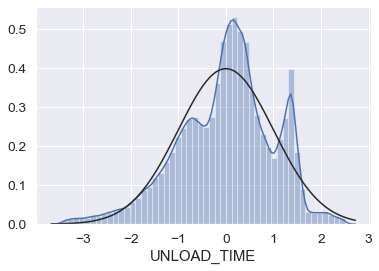

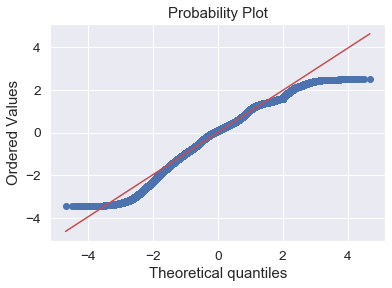

In [190]:
sns.distplot(df_train['UNLOAD_TIME'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train['UNLOAD_TIME'], plot=plt)

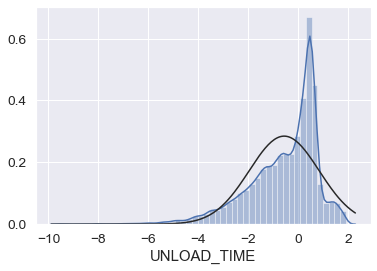

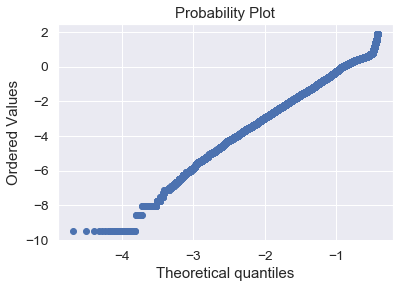

In [128]:
#  处理偏度，峰度
df_train['UNLOAD_TIME'] = np.log(df_train['UNLOAD_TIME'])

sns.distplot(df_train['UNLOAD_TIME'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train['UNLOAD_TIME'], plot=plt)

In [191]:
df_train.shape

(479037, 14)

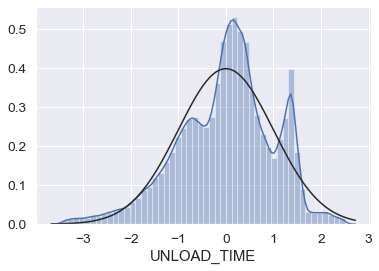

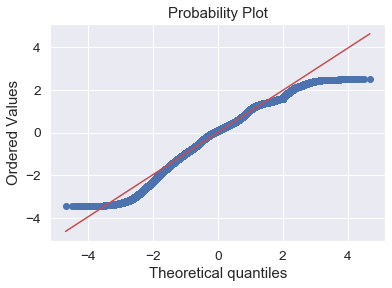

In [193]:
sns.distplot(df_train['UNLOAD_TIME'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train['UNLOAD_TIME'], plot=plt)

In [194]:
df_train.to_csv('df_train.csv',index= False)

In [195]:
df_train.columns

Index(['PICK_UP_EARLIST', 'RECEIVE_VOLUME', 'BUSINESS_TYPE', 'VOLUME',
       'WEIGHT', 'QUANTITY', 'FIX_WEIGHT', 'FIX_VOLUME', 'UNLOAD_TIME_INT',
       'VEHICLE_LENGTH', 'EQUAL_VOLUME', 'UNLOAD_TIME', 'FREIGHT_BASIS_LABEL',
       'COMPANY_LABEL'],
      dtype='object')

In [270]:
df_train = df_train[['PICK_UP_EARLIST', 'RECEIVE_VOLUME', 'BUSINESS_TYPE', 
                 'VOLUME', 'WEIGHT','QUANTITY',
                 'VEHICLE_LENGTH', 'EQUAL_VOLUME', 'FREIGHT_BASIS_LABEL', 
                 'COMPANY_LABEL','UNLOAD_TIME']]
df_train.head()
df_train.shape

,PICK_UP_EARLIST,RECEIVE_VOLUME,BUSINESS_TYPE,VOLUME,WEIGHT,QUANTITY,VEHICLE_LENGTH,EQUAL_VOLUME,FREIGHT_BASIS_LABEL,COMPANY_LABEL,UNLOAD_TIME
0,2019-09-08 11:29:35,-1.066130,B,-0.222986,-0.494549,0.233030,0.456812,1,0,11,-0.131025
1,2019-09-08 11:29:35,-3.158378,B,0.990082,0.590985,0.618124,0.456812,1,0,11,-0.132566
2,2019-09-08 11:29:35,-1.217035,B,-1.010634,-1.391959,-1.640613,0.456812,1,0,11,-0.131795
3,2019-04-19 09:57:37,0.233843,B,-0.925253,-0.661241,-2.348280,-1.248052,1,0,20,-2.091182
4,2019-10-01 15:48:06,-1.419966,B,0.727231,0.937357,0.171636,0.456812,1,0,11,-2.282591


(479037, 11)

In [274]:
df_train['BUSINESS_TYPE'] = LabelEncoder().fit_transform(df_train['BUSINESS_TYPE']) 
df_train['PICK_UP_EARLIST'] = LabelEncoder().fit_transform(df_train['PICK_UP_EARLIST']) 


df_train['PICK_UP_EARLIST'] = StandardScaler().fit_transform(df_train['PICK_UP_EARLIST'][:,np.newaxis])

df_train.head(3)

,PICK_UP_EARLIST,RECEIVE_VOLUME,BUSINESS_TYPE,VOLUME,WEIGHT,QUANTITY,VEHICLE_LENGTH,EQUAL_VOLUME,FREIGHT_BASIS_LABEL,COMPANY_LABEL,UNLOAD_TIME
0,0.47204,-1.066130,0,-0.222986,-0.494549,0.233030,0.456812,1,0,11,-0.131025
1,0.47204,-3.158378,0,0.990082,0.590985,0.618124,0.456812,1,0,11,-0.132566
2,0.47204,-1.217035,0,-1.010634,-1.391959,-1.640613,0.456812,1,0,11,-0.131795


In [275]:
x = df_train.loc[:, [ 'RECEIVE_VOLUME', 'BUSINESS_TYPE', 
                 'VOLUME', 'WEIGHT','QUANTITY',
                 'VEHICLE_LENGTH', 'EQUAL_VOLUME', 'FREIGHT_BASIS_LABEL', 
                 'COMPANY_LABEL']]

y = df_train.loc[:, ['UNLOAD_TIME']]

In [277]:
x_train.shape

(335325, 9)

In [276]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [278]:
# y_train['UNLOAD_TIME'].values
# y_train.values
# y_train.UNLOAD_TIME.values

y_train_values = y_train['UNLOAD_TIME'].values
y_train_values

array([ 0.33048242,  1.38725101, -0.90752692, ..., -0.58377016,
       -0.8150445 ,  1.33463673])

In [299]:
y_test_values = y_test['UNLOAD_TIME'].values
y_test_values

array([ 1.86166348,  0.70226766,  1.34884456, ..., -0.03974086,
        0.55351035, -0.15221528])

In [303]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import explained_variance_score

In [282]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train_values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### 单模型

In [279]:
model_1 = Lasso(alpha =0.0005, random_state=1)
model_1.fit(x_train,y_train_values)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [307]:
y_pred = model_1.predict(x_test)
# y_pred
print("explained_variance_score: {:<8.5f}".format(explained_variance_score(y_test_values,y_pred)))    #  效果有点差。。

explained_variance_score: 0.14679 


In [283]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [286]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [287]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [288]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [310]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=0,
                             random_state =7, nthread = -1)

In [290]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

####  单模型得分

In [285]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.9242 (0.0026)



In [291]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.9242 (0.0026)



In [292]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: nan (nan)



In [293]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

KeyboardInterrupt: 

In [308]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[10:45:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:48:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:50:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [311]:
model_xgb.fit(x_train,y_train_values)
y_pred = model_xgb.predict(x_test)
print("explained_variance_score: {:<8.5f}".format(explained_variance_score(y_test_values,y_pred)))

[11:00:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, silent=0, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

explained_variance_score: 0.20507 


In [312]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.9000 (0.0025)



In [313]:
model_lgb.fit(x_train,y_train_values)
y_pred = model_lgb.predict(x_test)
print("explained_variance_score: {:<8.5f}".format(explained_variance_score(y_test_values,y_pred)))

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

explained_variance_score: 0.19349 


####  融合模型

In [315]:
# 单模型效果太差了，
# 感觉用处不大。。。